In [1]:
import yaml
import sys
import os
import gc
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from keras import backend as K
from collections import OrderedDict
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from evml.reliability import compute_calibration, reliability_diagram, reliability_diagrams

import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
from functools import partial

from imblearn.under_sampling import RandomUnderSampler
from imblearn.tensorflow import balanced_batch_generator

2022-09-29 13:20:06.435698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 13:20:06.653884: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 13:20:06.693848: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-29 13:20:07.755375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
config = "../config/p-type.yml"
with open(config) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [3]:
def build_model(input_size, 
                hidden_size, 
                num_hidden_layers, 
                output_size, 
                activation, 
                dropout_rate):
    
    model = tf.keras.models.Sequential()
        
    if activation == 'leaky':
        model.add(tf.keras.layers.Dense(input_size))
        model.add(tf.keras.layers.LeakyReLU())
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
            else:
                model.add(tf.keras.layers.Dense(hidden_size))
                model.add(tf.keras.layers.LeakyReLU())
                model.add(tf.keras.layers.Dropout(dropout_rate))
    else:
        model.add(tf.keras.layers.Dense(input_size, activation=activation))
        
        for i in range(num_hidden_layers):
            if num_hidden_layers == 1:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
            else:
                model.add(tf.keras.layers.Dense(hidden_size, activation=activation))
                model.add(tf.keras.layers.Dropout(dropout_rate))
      
    #model.add(DenseDirichlet(output_size))
    model.add(tf.keras.layers.Dense(output_size, activation='linear'))
    
    return model

In [4]:
# lgamma = tf.math.lgamma
# digamma = tf.math.digamma
        
# #epoch_callback = ReportEpoch()
# def KL(alpha, num_classes=4, weights = False):
#     one = K.constant(np.ones((1,num_classes)),dtype=tf.float32)
#     if weights is not False:
#         S = K.sum(weights*alpha, axis=1, keepdims=True)
#         A1 = K.sum(weights*lgamma(alpha), axis=1, keepdims=True)
#         A2 = K.sum(weights*lgamma(one), axis=1, keepdims=True)
#         A3 = lgamma(K.sum(weights*one, axis=1, keepdims=True))
#         A4 = K.sum(weights*(alpha - one)*(digamma(alpha)-digamma(S)), axis=1, keepdims=True)
#     else:
#         S = K.sum(alpha, axis=1, keepdims=True)
#         A1 = K.sum(lgamma(alpha), axis=1, keepdims=True)
#         A2 = K.sum(lgamma(one), axis=1, keepdims=True)
#         A3 = lgamma(K.sum(one, axis=1, keepdims=True))
#         A4 = K.sum((alpha - one)*(digamma(alpha)-digamma(S)), axis=1, keepdims=True)
#     kl = lgamma(S) - A1 + A2 - A3 + A4
#     return kl

# def loss_func(y_true, output, callback = False, weights = False):
#     y_evidence = K.relu(output)
#     alpha = y_evidence + 1
    
#     S = K.sum(alpha, axis=1, keepdims=True)
#     p = alpha / S  

#     if weights is not False:
#         err = K.sum(weights * K.pow((y_true-p), 2), axis=1, keepdims=True)
#         var = K.sum(weights * alpha * (S-alpha) / (S*S*(S+1)), axis=1, keepdims=True)
#     else:
#         err = K.sum(K.pow((y_true-p), 2), axis=1, keepdims=True)
#         var = K.sum(alpha*(S-alpha) / (S*S*(S+1)), axis=1, keepdims=True)
        
#     l = K.sum(err + var, axis=1, keepdims=True)
#     l = K.sum(l)
    
#     kl = K.minimum(1.0, callback.this_epoch/callback.annealing_coeff) #* K.sum(KL((1-y_true)*(alpha)+y_true))
#     kl *= K.sum(KL((1-y_true)*(alpha)+y_true, weights = weights))
#     return l + kl

In [5]:
def Dirichlet(y, output, callback = False, weights = False):
    
    def KL(alpha):
        beta=tf.constant(np.ones((1, alpha.shape[1])), dtype=tf.float32)
        S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
        S_beta = tf.reduce_sum(beta, axis=1, keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha), axis=1, keepdims=True)
        lnB_uni = tf.reduce_sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        if weights is not False:
            kl = tf.reduce_sum(weights * (alpha - beta)*(dg1-dg0), axis=1, keepdims=True) + lnB + lnB_uni
        else:
            kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
        return kl
    
    evidence = K.relu(output)
    alpha = evidence + 1
    
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    m = alpha / S

    if weights is not False:
        A = tf.reduce_sum(weights * (y-m)**2, axis=1, keepdims=True)
        B = tf.reduce_sum(weights * alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)
    else:
        A = tf.reduce_sum((y-m)**2, axis=1, keepdims=True)
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)

    annealing_coef = tf.minimum(1.0, callback.this_epoch/callback.annealing_coeff)
    alpha_hat = y + (1-y)*alpha
    C = annealing_coef * KL(alpha_hat)
    C = tf.reduce_mean(C, axis=1)
    return tf.reduce_mean(A + B + C)

In [6]:
def calc_prob_uncertinty(outputs, num_classes = 4):
    evidence = K.relu(outputs)
    alpha = evidence + 1
    u = num_classes / K.sum(alpha, axis=1, keepdims=True)
    prob = alpha / K.sum(alpha, axis=1, keepdims=True)
    return prob.numpy(), u.numpy()

In [7]:
class ReportEpoch(tf.keras.callbacks.Callback):
    def __init__(self, annealing_coeff):
        super(ReportEpoch, self).__init__()
        self.this_epoch = 0
        self.annealing_coeff = annealing_coeff
    def on_epoch_begin(self, epoch, logs={}):
        self.this_epoch += 1

In [8]:
if not os.path.isfile(os.path.join(conf['data_path'], "cached.parquet")):
    df = pd.concat([
        pd.read_parquet(x) for x in tqdm.tqdm(glob.glob(os.path.join(conf['data_path'], "*.parquet")))
    ])
    df.to_parquet(os.path.join(conf['data_path'], "cached.parquet"))
else:
    df = pd.read_parquet(os.path.join(conf['data_path'], "cached.parquet"))

### Split and preprocess the data
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])
df["id"] = range(df.shape[0])

In [9]:
# Need the same test_data for all trained models (data and model ensembles)
#n_splits = 10
data_seed = 0
flat_seed = 1000
gsp = GroupShuffleSplit(n_splits=conf["trainer"]["n_splits"],
                        random_state = flat_seed, 
                        train_size=conf["trainer"]["train_size1"])
splits = list(gsp.split(df, groups = df["day"]))
train_index, test_index = splits[0]
train_data, test_data = df.iloc[train_index].copy(), df.iloc[test_index].copy() 

# Make N train-valid splits using day as grouping variable
gsp = GroupShuffleSplit(n_splits=conf["trainer"]["n_splits"],
                        random_state = flat_seed, 
                        train_size=conf["trainer"]["train_size2"])
splits = list(gsp.split(train_data, groups = train_data["day"]))
train_index, valid_index = splits[data_seed]
train_data, valid_data = train_data.iloc[train_index].copy(), train_data.iloc[valid_index] .copy() 

In [10]:
features = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
outputs = conf['outputvars']
num_classes = len(outputs)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(train_data[features])
x_valid = scaler_x.transform(valid_data[features])
x_test = scaler_x.transform(test_data[features])
y_train = tf.keras.utils.to_categorical(np.argmax(train_data[outputs].to_numpy(), 1), num_classes)
y_valid = tf.keras.utils.to_categorical(np.argmax(valid_data[outputs].to_numpy(), 1), num_classes)
y_test = tf.keras.utils.to_categorical(np.argmax(test_data[outputs].to_numpy(), 1), num_classes)

In [32]:
train_idx = np.argmax(train_data[outputs].to_numpy(), 1)

weights = sklearn.utils.class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_idx), 
            y = train_idx)

In [55]:
weights = np.array([ 0.37939381,  0.96543804,  30.0 , 15.0])

In [56]:
training_generator, steps_per_epoch = balanced_batch_generator(
    x_train,
    y_train,
    sample_weight=np.array([weights[l] for l in train_idx]),
    sampler=RandomUnderSampler(),
    batch_size=conf["trainer"]["batch_size"],
    random_state=flat_seed,
)

In [57]:
try:
    del mlp
    K.clear_session()
    gc.collect()
except:
    pass

In [58]:
mlp = build_model(len(features), 
                  conf["trainer"]["hidden_sizes"], 
                  conf["trainer"]["num_hidden_layers"], 
                  len(outputs), 
                  conf["trainer"]["activation"], 
                  conf["trainer"]["dropout_rate"])

mlp.build((conf["trainer"]["batch_size"], len(features)))
mlp.summary()

#mlp = MLP(hidden_size, dropout, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (2048, 268)               72092     
                                                                 
 leaky_re_lu (LeakyReLU)     (2048, 268)               0         
                                                                 
 dense_1 (Dense)             (2048, 128)               34432     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (2048, 128)               0         
                                                                 
 dropout (Dropout)           (2048, 128)               0         
                                                                 
 dense_2 (Dense)             (2048, 128)               16512     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (2048, 128)               0

In [59]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=conf["trainer"]["learning_rate"]
)

In [60]:
annealing_coeff = 50
epoch_callback = ReportEpoch(annealing_coeff)
#weights = np.array(conf["trainer"]["outputvar_weights"])
#weights /= weights.sum()

criterion = partial(
    Dirichlet,
    callback = epoch_callback, 
    weights = False
)

# compile model
mlp.compile(
    optimizer = optimizer, 
    loss = criterion,
    metrics = ["accuracy",
               tf.keras.metrics.Precision(name="prec"),
               tf.keras.metrics.Recall(name="recall"),
               tfa.metrics.F1Score(num_classes=num_classes,
                                   average='macro', name="f1"),
               tf.keras.metrics.AUC(name = "auc")]
    #run_eagerly=True
)

In [61]:
# create early stopping callback
callback1 = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_f1', 
    mode = 'max',
    patience = 15,
    restore_best_weights = True
)

# create reduce LR callback
callback2 = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_f1', 
    factor = 0.1, 
    patience = 3, 
    verbose = 0,
    mode = 'max',
    min_lr = 1e-7
)

In [62]:
# fit model to training data
sample_weight = np.array([weights[l] for l in train_idx])

history = mlp.fit(
    training_generator, 
    steps_per_epoch=steps_per_epoch,
#     x = x_train, 
#     y = y_train,
#     sample_weight = sample_weight,
#     batch_size = conf["trainer"]["batch_size"],
    validation_data = (x_valid, y_valid),
    epochs = conf["trainer"]["epochs"],
    callbacks = [epoch_callback, callback1, callback2],
    verbose = 1,
    shuffle = True
)

Epoch 1/1000
15/15 [==============================] - 5s 266ms/step - loss: 7.8023 - accuracy: 0.5232 - prec: 0.3710 - recall: 0.8037 - f1: 0.5085 - auc: 0.7020 - val_loss: 0.4505 - val_accuracy: 0.7092 - val_prec: 0.4301 - val_recall: 0.8721 - val_f1: 0.5331 - val_auc: 0.7590 - lr: 0.0010
Epoch 2/1000
15/15 [==============================] - 3s 239ms/step - loss: 6.6924 - accuracy: 0.6069 - prec: 0.4040 - recall: 0.8972 - f1: 0.6040 - auc: 0.7464 - val_loss: 0.3712 - val_accuracy: 0.7660 - val_prec: 0.5035 - val_recall: 0.9150 - val_f1: 0.5756 - val_auc: 0.8236 - lr: 0.0010
Epoch 3/1000
15/15 [==============================] - 3s 233ms/step - loss: 6.1031 - accuracy: 0.6508 - prec: 0.4388 - recall: 0.9013 - f1: 0.6454 - auc: 0.7802 - val_loss: 0.3284 - val_accuracy: 0.7927 - val_prec: 0.5494 - val_recall: 0.9164 - val_f1: 0.6055 - val_auc: 0.8486 - lr: 0.0010
Epoch 4/1000
15/15 [==============================] - 3s 236ms/step - loss: 5.7874 - accuracy: 0.6732 - prec: 0.4653 - recall: 

In [63]:
preds = mlp.predict(x_test)

1261/1261 [==============================] - 1s 933us/step


In [64]:
prob, u = calc_prob_uncertinty(preds)

In [65]:
true_labels = np.argmax(test_data[outputs].to_numpy(), 1)
pred_labels = np.argmax(prob, 1)
confidences = np.take_along_axis(
    prob,
    pred_labels[:, None], 
    axis=1
)

test_data["true_labels"] = true_labels
test_data["pred_labels"] = pred_labels
test_data["pred_conf"] = confidences
test_data["pred_sigma"] = u
test_data["accuracy"] = (test_data["pred_labels"] == test_data["true_labels"]).to_numpy()

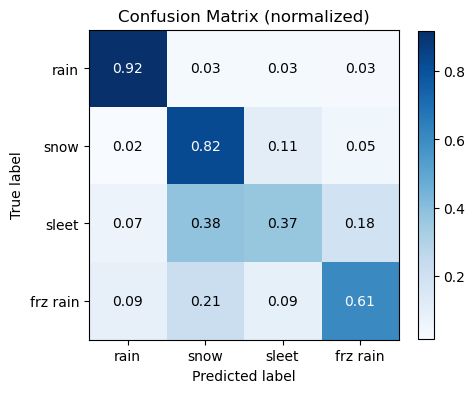

In [66]:
def plot_confusion_matrix(y_true, y_pred, classes, model_name, normalize=False, title=None, cmap=plt.cm.Blues, filename=None):
    """
    Function to plot a confusion matrix. 
    """
    if not title:
        if normalize:
            title = 'Confusion Matrix (normalized)'
        else:
            title = 'Confusion Matrix'

    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink=0.80)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, fontsize=10)
    ax.set_yticklabels(classes, fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('True label', fontsize=10)
    ax.set_xlabel('Predicted label', fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                   fontsize=10)
            
    if filename:
        path = f'/glade/u/home/jwillson/winter-ptype/images/{model_name}/'
        plt.savefig(path + filename, dpi=300, bbox_inches="tight")
        
    return ax


plot_confusion_matrix(test_data["true_labels"], 
                      test_data["pred_labels"], 
                      ["rain", "snow", "sleet", "frz rain"], 
                      "MLP", 
                      normalize=True,
                      title=f'Confusion Matrix (normalized)')#, filename='cm_norm.png')

plt.show()

In [68]:
results_calibration = compute_calibration(
    true_labels, 
    pred_labels, 
    confidences, 
    num_bins=10)

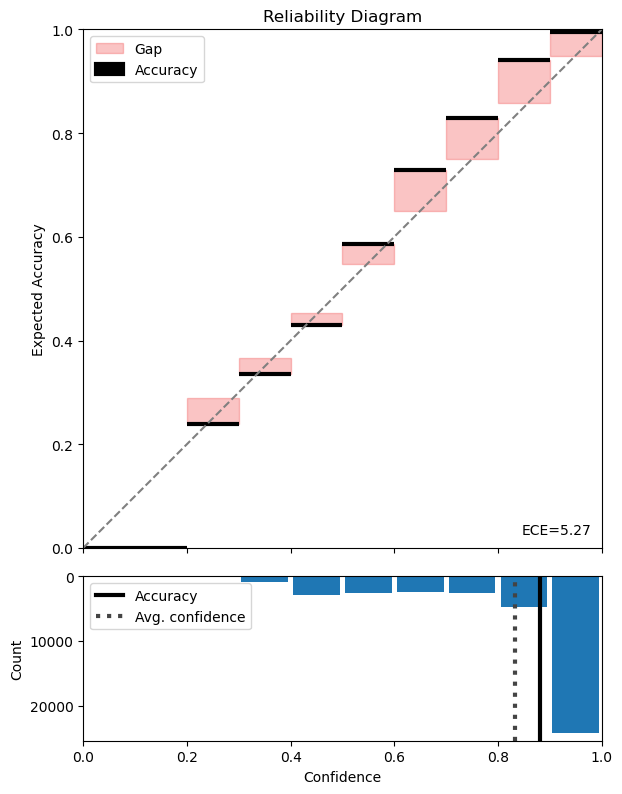

In [69]:
reliability_diagram(
    true_labels, 
    pred_labels, 
    confidences, 
    num_bins=10, dpi=100)

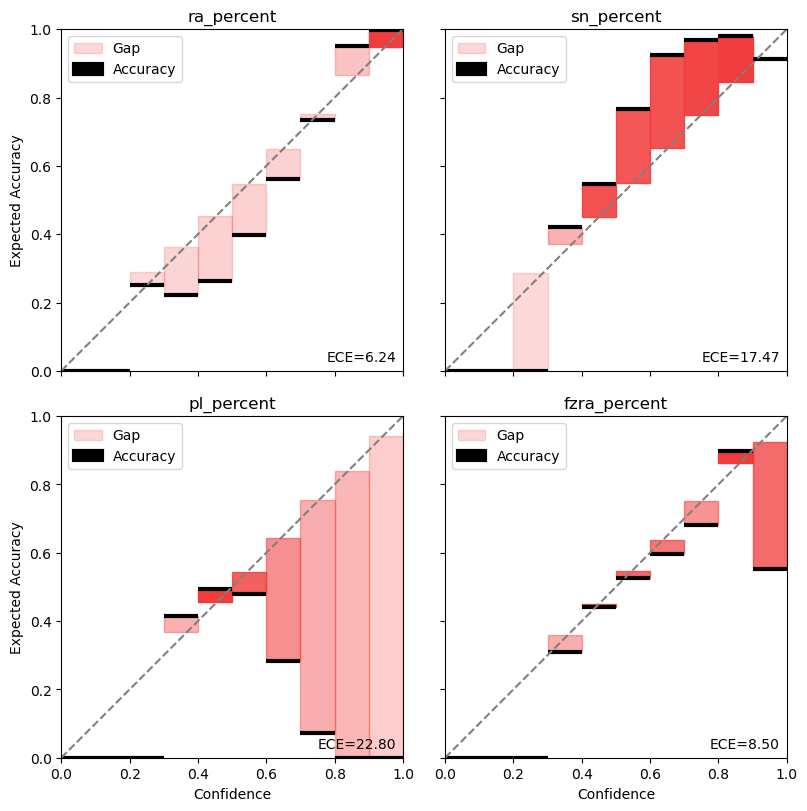

In [70]:
results = OrderedDict()
for label in range(num_classes):
    cond = (test_data["true_labels"] == label)
    results[outputs[label]] = {
        "true_labels": test_data[cond]["true_labels"].values, 
        "pred_labels": test_data[cond]["pred_labels"].values, 
        "confidences": test_data[cond]["pred_conf"].values
    }
fig = reliability_diagrams(results, num_bins=10, draw_bin_importance="alpha",
                           num_cols=2, dpi=100, return_fig=True)

In [71]:
def compute_cov(df, col = "pred_conf", quan = "uncertainty", ascending = False):
    df = df.copy()
    df = df.sort_values(col, ascending = ascending)
    df["dummy"] = 1
    df[f"cu_{quan}"] = df[quan].cumsum() / df["dummy"].cumsum()
    df[f"cu_{col}"] = df[col].cumsum() / df["dummy"].cumsum()
    df[f"{col}_cov"] = df["dummy"].cumsum() / len(df)
    return df

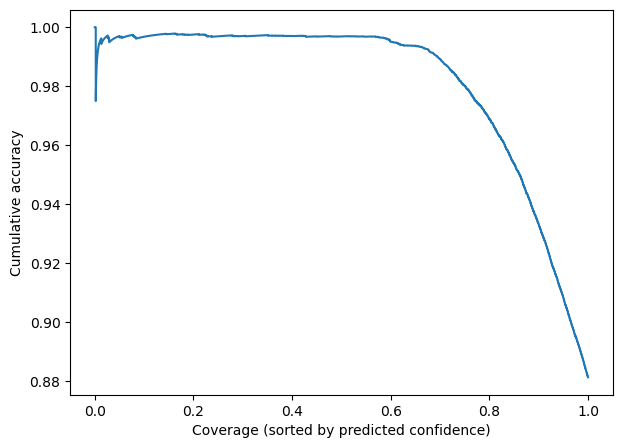

In [72]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
    
_test_data_sorted = compute_cov(test_data, col = "pred_conf", quan = "accuracy")
ax.plot(
    _test_data_sorted["pred_conf_cov"],
    _test_data_sorted["cu_accuracy"]
)
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")
plt.show()

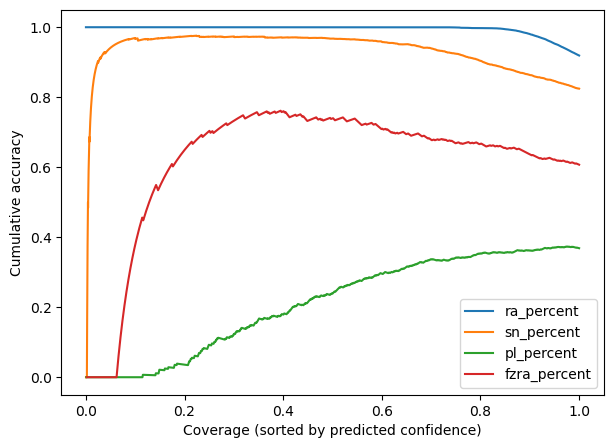

In [73]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
    
for label in range(num_classes):
    cond = (test_data["true_labels"] == label)
    _test_data_sorted = compute_cov(test_data[cond], col = "pred_conf", quan = "accuracy")
    ax.plot(
        _test_data_sorted["pred_conf_cov"],
        _test_data_sorted["cu_accuracy"]
    )
    
ax.set_ylabel("Cumulative accuracy")
ax.set_xlabel("Coverage (sorted by predicted confidence)")
plt.legend(outputs)
plt.show()

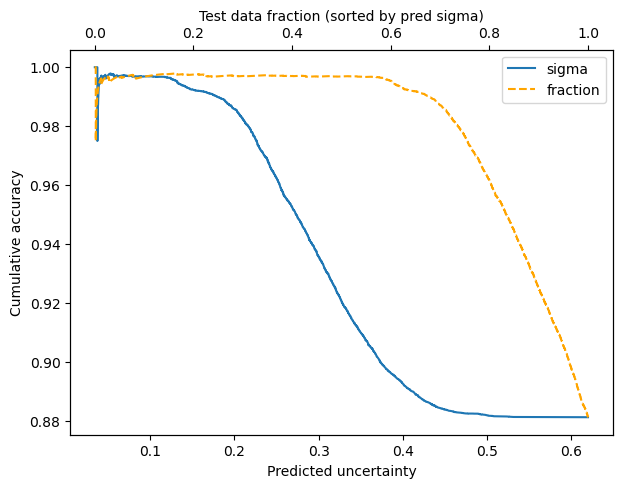

In [74]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)

test_data_sorted = compute_cov(test_data, col = "pred_sigma", quan = "accuracy", ascending = True)

l1, = ax.plot(
    test_data_sorted["pred_sigma"],
    test_data_sorted["cu_accuracy"],
    label = "sigma"
)

ax2 = ax.twiny()
l2, = ax2.plot(
    test_data_sorted["pred_sigma_cov"],
    test_data_sorted["cu_accuracy"], 
    color='orange', ls = "--", 
    label = "fraction")

ax.set_ylabel("Cumulative accuracy")
ax2.set_xlabel("Test data fraction (sorted by pred sigma)")
ax.set_xlabel("Predicted uncertainty")

plt.legend([l1, l2], ["sigma", "fraction"])

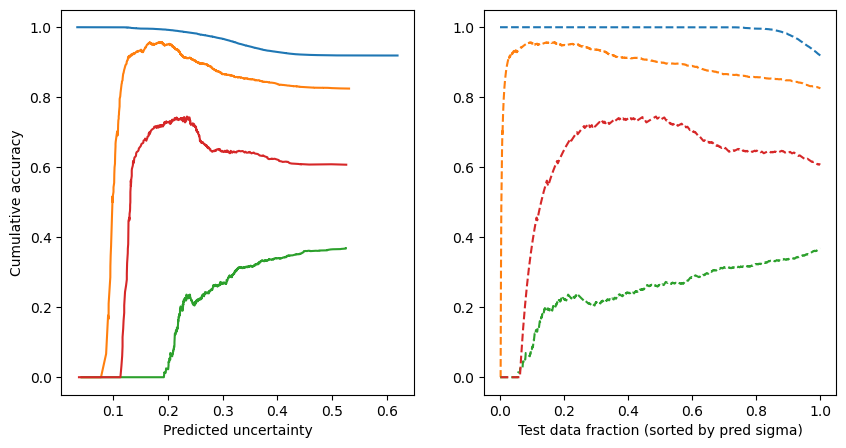

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey='col')

for label in range(num_classes):
    c = (test_data["true_labels"] == label)
    _test_data_sorted = compute_cov(test_data[c], col = "pred_sigma", quan = "accuracy", ascending = True)
    ax[0].plot(
        _test_data_sorted["pred_sigma"],
        _test_data_sorted["cu_accuracy"]
    )
    _test_data_sorted = compute_cov(test_data[c], col = "pred_sigma", quan = "accuracy", ascending = True)
    ax[1].plot(
        _test_data_sorted["pred_sigma_cov"],
        _test_data_sorted["cu_accuracy"],
        ls = "--"
    )
    
ax[0].set_ylabel("Cumulative accuracy")
#ax[0].set_xlabel("Coverage (sorted by predicted uncertainty)")

ax[1].set_xlabel("Test data fraction (sorted by pred sigma)")
ax[0].set_xlabel("Predicted uncertainty")


plt.show()